### Mechanics of a Simple RNN
- Before looking at more complicated RNNS let's get the basics down
- Let's start with the simple example of classifying the sentiment of sentence 
- This will:
    - Give us a good sense of how RNNs work
    - Understand the mechanics and "best practices"
    - Will not give good the best results (why?)

In [1]:
# --- Libraries ---
# - Base libs - 
import os
import numpy as np

# -Tensorflow-
import tensorflow as tf
from tensorflow.python.client import device_lib
# -Keras libs-
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint


# -Plot libs-
import matplotlib.pyplot as plt
from IPython.display import SVG, display
#%matplotlib inline

Using TensorFlow backend.


In [2]:
# --- Set base path ---
cwd = os.getcwd()

In [3]:
# --- Config Check --- 
# - GPU: Check -
print(device_lib.list_local_devices())

# - Ensuring we have sufficient buffer size -
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# - Creating session -
sess = tf.Session(config=config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17892017397674095442
]


In [4]:
# --- Preparing the IMDB Data ---
from keras.datasets import imdb
from keras.preprocessing import sequence

# Max number of words
max_features = 10000

# Max length of sentence
maxlen = 64 

# Max number of comments read in at at ime
batch_size = 64

print('...Loading Data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequence (sample x time)')
input_train = sequence.pad_sequences(input_train, maxlen = maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

...Loading Data...
25000 train sequences
25000 test sequences
Pad sequence (sample x time)
input_train shape: (25000, 64)
input_test shape: (25000, 64)


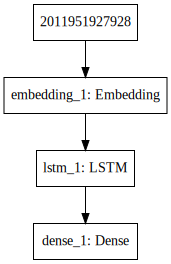

In [5]:
# --- Training model: Embedding + RNN ---
model = Sequential()
model.add(Embedding(max_features, 32))
#model.add(SimpleRNN(32))
#model.add(GRU(32))
model.add(LSTM(32))
model.add(Dense(1, activation ='sigmoid'))

# --- Visualizing the model ---
show_model_now = True
if (show_model_now):
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
else:
    # saves model in directory
    plot_model(model,
               to_file=os.path.join(cwd,'model.png'))

In [6]:
# --- Locations to save model ---
save_path_weights = os.path.join(cwd,'rnn_weights.h5')
save_path_model = os.path.join(cwd,'rnn_model.h5')

# --- Compile Model ---
#Compile model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

# If we want to checkpoint our model so we don't rerun it
checkpointer = ModelCheckpoint(filepath=save_path_weights, 
                               verbose=1, save_best_only=True)


# Verbose=0 -> to avoid jupyter notebook freezing
history = model.fit(input_train, y_train, 
                    epochs = 3, batch_size = 64, 
                    validation_split = 0.2,verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 14s 678us/step - loss: 0.4877 - acc: 0.7612 - val_loss: 0.3982 - val_acc: 0.8174
Epoch 2/3
20000/20000 [==============================] - 12s 606us/step - loss: 0.3326 - acc: 0.8599 - val_loss: 0.3919 - val_acc: 0.8256
Epoch 3/3
20000/20000 [==============================] - 12s 608us/step - loss: 0.2892 - acc: 0.8805 - val_loss: 0.4298 - val_acc: 0.8104


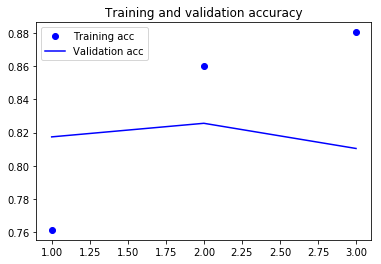

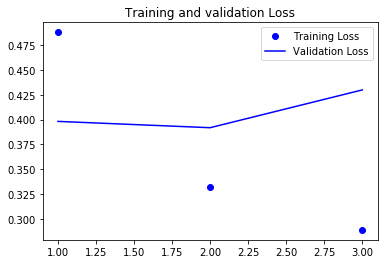

In [7]:
# --- Plotting performance ---
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation Loss')
plt.legend()

plt.show()

In [8]:
# --- Save Model ---
# Saves as an HDF5 file
model.save(save_path_model) 

In [9]:
# --- Loading the model ---
# There are two appraoches to load models
#    1. Store only the weights 
#    2. Store the model + weights

# - Method 1: Weights -
#model = create_model()
# Note we are loading the weights back into the model
# that is the model still needs to be instantiated
# model.load_weights(os.path.join(cwd,'rnn_model.h5'))

# - Method 2: Recall entire model -
from keras.models import load_model
model = load_model(save_path_model)

In [10]:
# --- Getting the right format ---
# Recall:
#     - The input_train is a matrix of indeces for words
#     - The first 3 elements are reserved characters

# Word-index key
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])
reverse_word_index
#.get(key, default return)
print('Word at index 5:' + str( reverse_word_index.get(5,'?'))) 

# Decoding the sentence
decoded_imdb = ' '.join([reverse_word_index.get(i-3,'?') for i in input_train[1]])
decoded_imdb

Word at index 5:to


"that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

In [11]:
# --- Predicting a value ---
new_input = [word_index.get(i,'?') for i in 'this was a good good movie'.split()]
value_in = sequence.pad_sequences([new_input], maxlen = maxlen)
test_values = np.append([input_test[0]],value_in , axis = 0)
model.predict_classes(test_values)
#input_train[1]

array([[0],
       [1]])

In [12]:
# ===========================================
# - Training model: Embedding + Stacked RNN -
# ===========================================

# =====================================================
# Exercise does a stacked unit give you better results?
# =====================================================
model_stacked_rnn = Sequential()
model_stacked_rnn.add(Embedding(max_features, 32))
model_stacked_rnn.add(SimpleRNN(32, return_sequences = True))
model_stacked_rnn.add(SimpleRNN(32, return_sequences = True))
model_stacked_rnn.add(SimpleRNN(32))
model_stacked_rnn.add(Dense(1, activation ='sigmoid'))

model_stacked_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


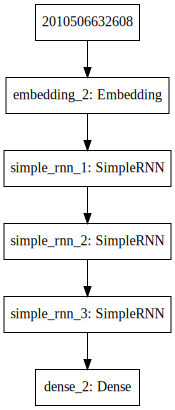

In [13]:
# - Visualizing the model -
show_model_now = True
if (show_model_now):
    display(SVG(model_to_dot(model_stacked_rnn).create(prog='dot', format='svg')))
else:
    plot_model(model_stacked_rnn, 
               to_file=os.path.join(cwd,'model_stacked_rnn.png'))

In [14]:
#Compile model
model_stacked_rnn.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

#To run tensboard use the following command in another terminal:
# tensorboard --logdir=logsTB/
tensorboard = TensorBoard(log_dir=os.path.join(cwd,'logsTB'), 
                           histogram_freq=1, write_graph=True, write_images=False)
model_stacked_rnn.fit(input_train, y_train, 
          epochs = 5, batch_size = 64, 
          callbacks=[tensorboard],
          validation_split = 0.2,verbose=0
          )